# Mgd (Multivariate Gaussian Distribution) Test
***
In this notebook, I'll try to use my *Multivariate Gaussian Distribution* implementation (Mgd) over a simple datasets I created, this training data consists of 28 surface points ~ approx following ~ a Gaussian Distribution, these samples are either labeled 0 (no anomaly) or 1 (anomaly).

First of all, we import:
1. *numpy* for linear algebra (matrix handling) though it's not required, it's already imported by LinearReg
2. *matplotlib.pyplot* & Axes3D  to do some plotting and see the results
3. *pandas* to load the data from a csv file
4. *Mgd* (personal implementation)

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from Mgd import Mgd # my Multivariate Gaussian Distribution implementation

Now let's load our dataset:

In [21]:
data = pd.read_csv('./datasets/Mgd.csv')
data.head(4)

,ID,x1,x2,y
0,0,0.0,0.00,0
1,1,0.0,0.70,0
2,2,-0.5,0.50,0
3,3,-0.5,1.23,0


Now let's visualize the data and see approximatively how it's distributed

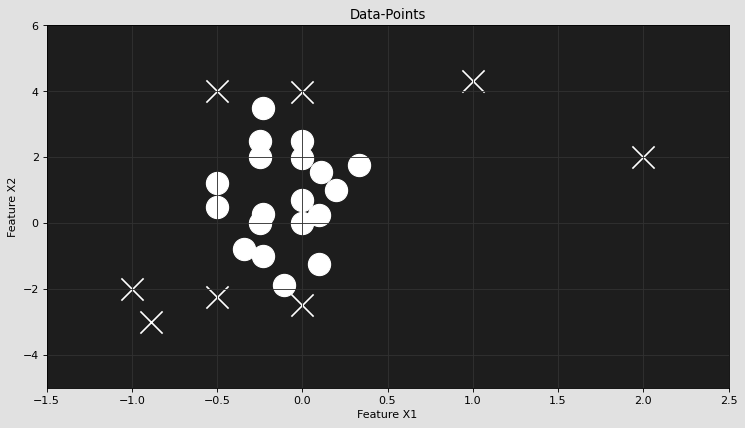

In [22]:
X = data.iloc[:, 1:3].to_numpy(dtype=np.float32)
y = data.iloc[:, 3].to_numpy(dtype=np.int32)

X1 = X[:, 0]  # feature 1
X2 = X[:, 1]  # feature 2

X1_True = np.array([x1 for ind, x1 in enumerate(X1) if y[ind] == 1])  # x1's labeled true (1)
X2_True = np.array([x2 for ind, x2 in enumerate(X2) if y[ind] == 1])  # x2's labeled true (1)

X1_False = np.array([x1 for ind, x1 in enumerate(X1) if y[ind] == 0])  # x1's labeled true (0))
X2_False = np.array([x2 for ind, x2 in enumerate(X2) if y[ind] == 0])  # x2's labeled true (0)

fig = plt.figure(figsize=(11, 6), dpi=80, facecolor='#e1e1e1')
ax = fig.add_subplot(111)
ax.set_facecolor('#1d1d1d')  # some dark background

ax.scatter(X1_True, X2_True, marker='x', c='w', s=400)
ax.scatter(X1_False, X2_False, marker='o', c='w', s=400)

plt.ylim((-5, 6))  # y axis range
plt.xlim((-1.5, 2.5))  # x axis range

plt.title('Data-Points')
plt.xlabel('Feature X1')
plt.ylabel('Feature X2')

plt.grid(color='#313131')

plt.show()  # show plot

Our datapoints seem to be around the mean, a gaussian model will fit well! so let's fit our *Mdg* model

In [23]:
model = Mgd().fit(X, verbose=1)

Mean vector of training data successfully computed!
Covariance matrix of training data successfully computed!
Covariance inverse matrix of training data successfully computed!
Covariance matrix determinant of training data successfully computed!


Fitting the Multivariate gaussian destribution model refers here to compute the different params used for prediction i.e. compute:
1. the covariance matrix if none is specified
2. the mean vector if none is specified
3. the inverse of the covariance matrix
4. the determinant of the covariance matrix

Now the challenge is to set a reasonable threshold on predictions and/or modify the covariance matrix to get the best precision/recall trade off, below I set the threshold to the mean of the highest density image of the anomalous samples and the least of the non anoumalous examples. 

In [24]:
y_pred = np.sort(model.predict(X, prob=1))
n_anomalous = np.count_nonzero(y) # how many anomalous samples present in the data

custom_thresh = (y_pred[n_anomalous - 1] + y_pred[n_anomalous - 1]) /2

print('threshold set to ', custom_thresh)

threshold set to  0.01917111783905923


Now we have our custon threshold, we can score our model, get the confusion matrix and the other metrics; since this notebook aims to explain the MGD and for the few samples we have, I won't use any cross-validation nor a test set, everything is done over the training set. 

In [25]:
cmat, precision, recall, f1_score, accuracy = model.confusion_matrix(X, y, thresh=custom_thresh)

pd_cmat = pd.DataFrame(data=cmat, columns=['predicted-as-1', 'predicted-as-0'], 
                          index=['actual-1', 'actual-0'])

print('precision = ', precision)
print('recall = ', recall)
print('accuracy = ', accuracy)
print('___________________________________________')
print('Confusion Matrix:')
pd_cmat.head(2)

precision =  0.8888888888888888
recall =  0.8888888888888888
accuracy =  0.9285714285714286
___________________________________________
Confusion Matrix:


,predicted-as-1,predicted-as-0
actual-1,8,1
actual-0,1,18


The model provide a good overall recall & precision, but the recall isn't perfect, imagine this anomaly detection system if meant to spot fraudulent transactions so a chance our model missed one, on a two feature dataset we have some visualisation abilities to see where is the problem or what datapoints exactly cause the misclassification:

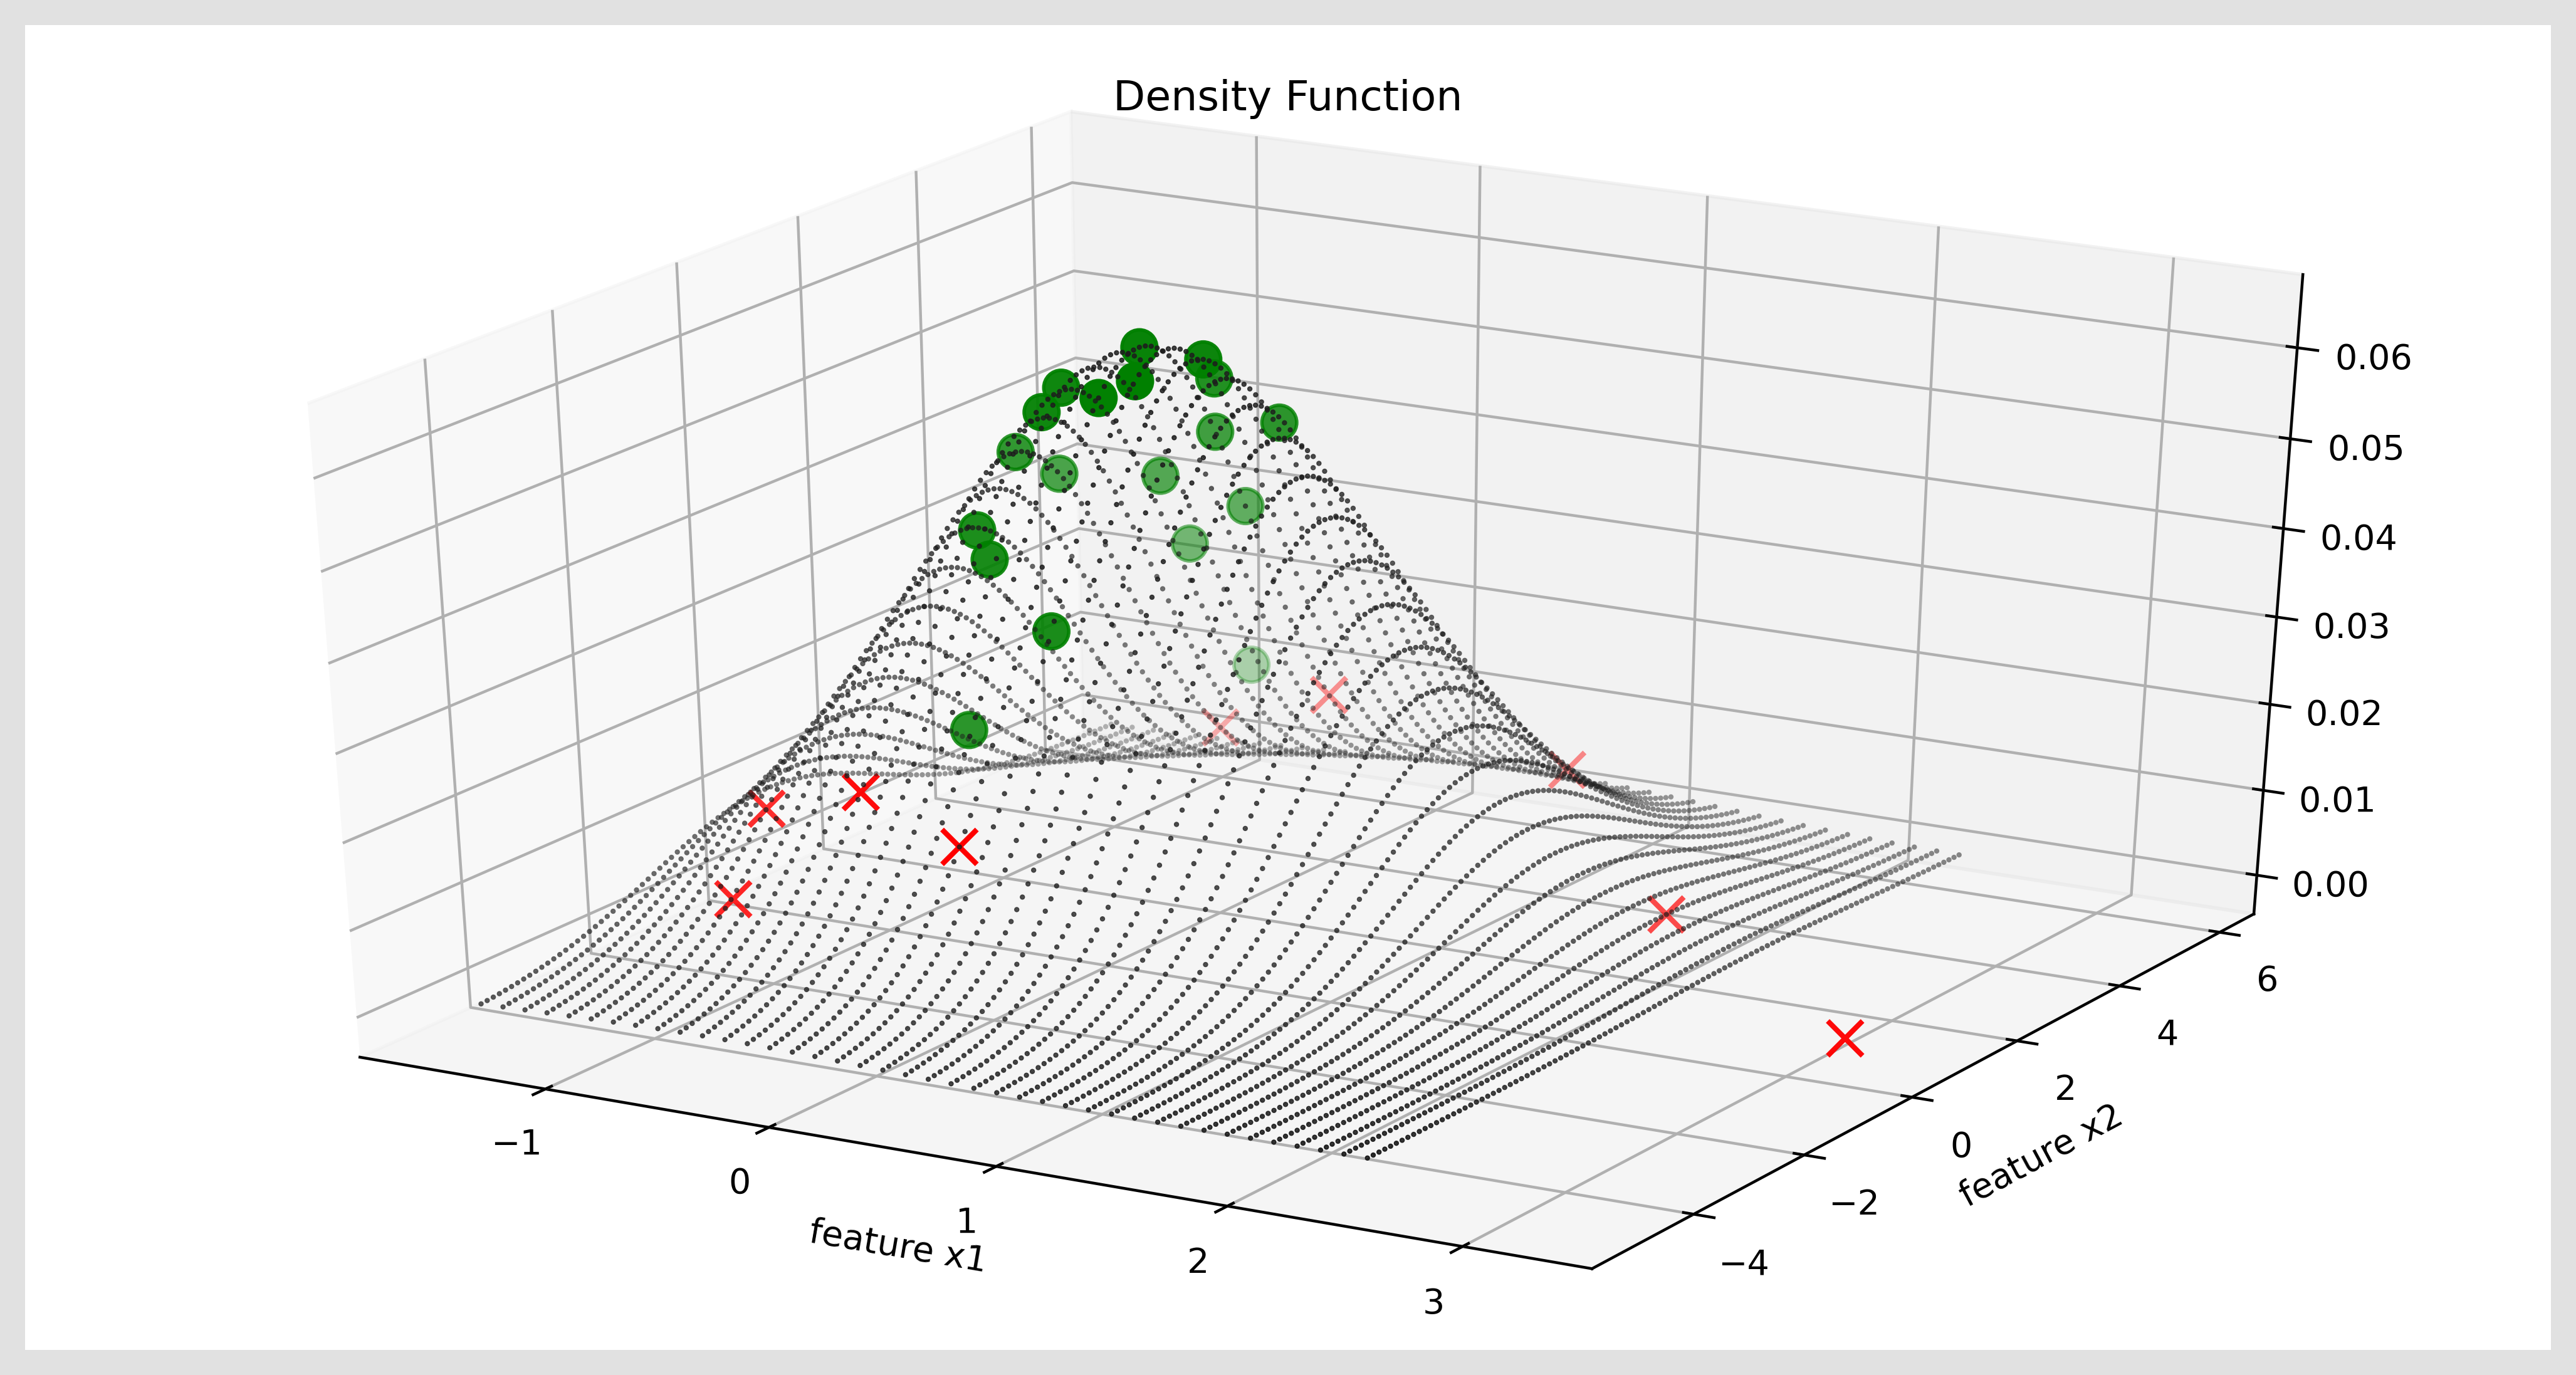

In [26]:
x1_range = np.arange(-1.5, 2.5, 0.1)
x2_range = np.arange(-5, 6, 0.1)
X_range = []
for x1 in x1_range:
    for x2 in x2_range:
        X_range.append([x1, x2])
X_range = np.array(X_range)

y_range = model.predict(X_range, prob=1, thresh=custom_thresh)
x1_range = X_range[:, 0]
x2_range = X_range[:, 1]

figure = plt.figure(figsize=(13, 7), dpi=400, facecolor='#e1e1e1')

ax_3d = figure.add_subplot(111, projection='3d')

ax_3d.scatter(x1_range, x2_range, y_range, marker='.', c='#1d1d1d', s=1)

mT = X1_True.shape[0]

X_range_true = np.zeros((mT, 2))
X_range_true[:, 0] = X1_True
X_range_true[:, 1] = X2_True

ax_3d.scatter(X1_True, X2_True, model.predict(X_range_true, prob=1), marker='x', c='r', s=100)


mF = X1_False.shape[0]

X_range_False = np.zeros((mF, 2))
X_range_False[:, 0] = X1_False
X_range_False[:, 1] = X2_False

ax_3d.scatter(X1_False, X2_False, model.predict(X_range_False, prob=1), marker='o', c='g', s=100)

plt.xlabel('feature x1')
plt.ylabel('feature x2')
plt.clabel('density')

ax_3d.set_title('Density Function')

plt.show() 


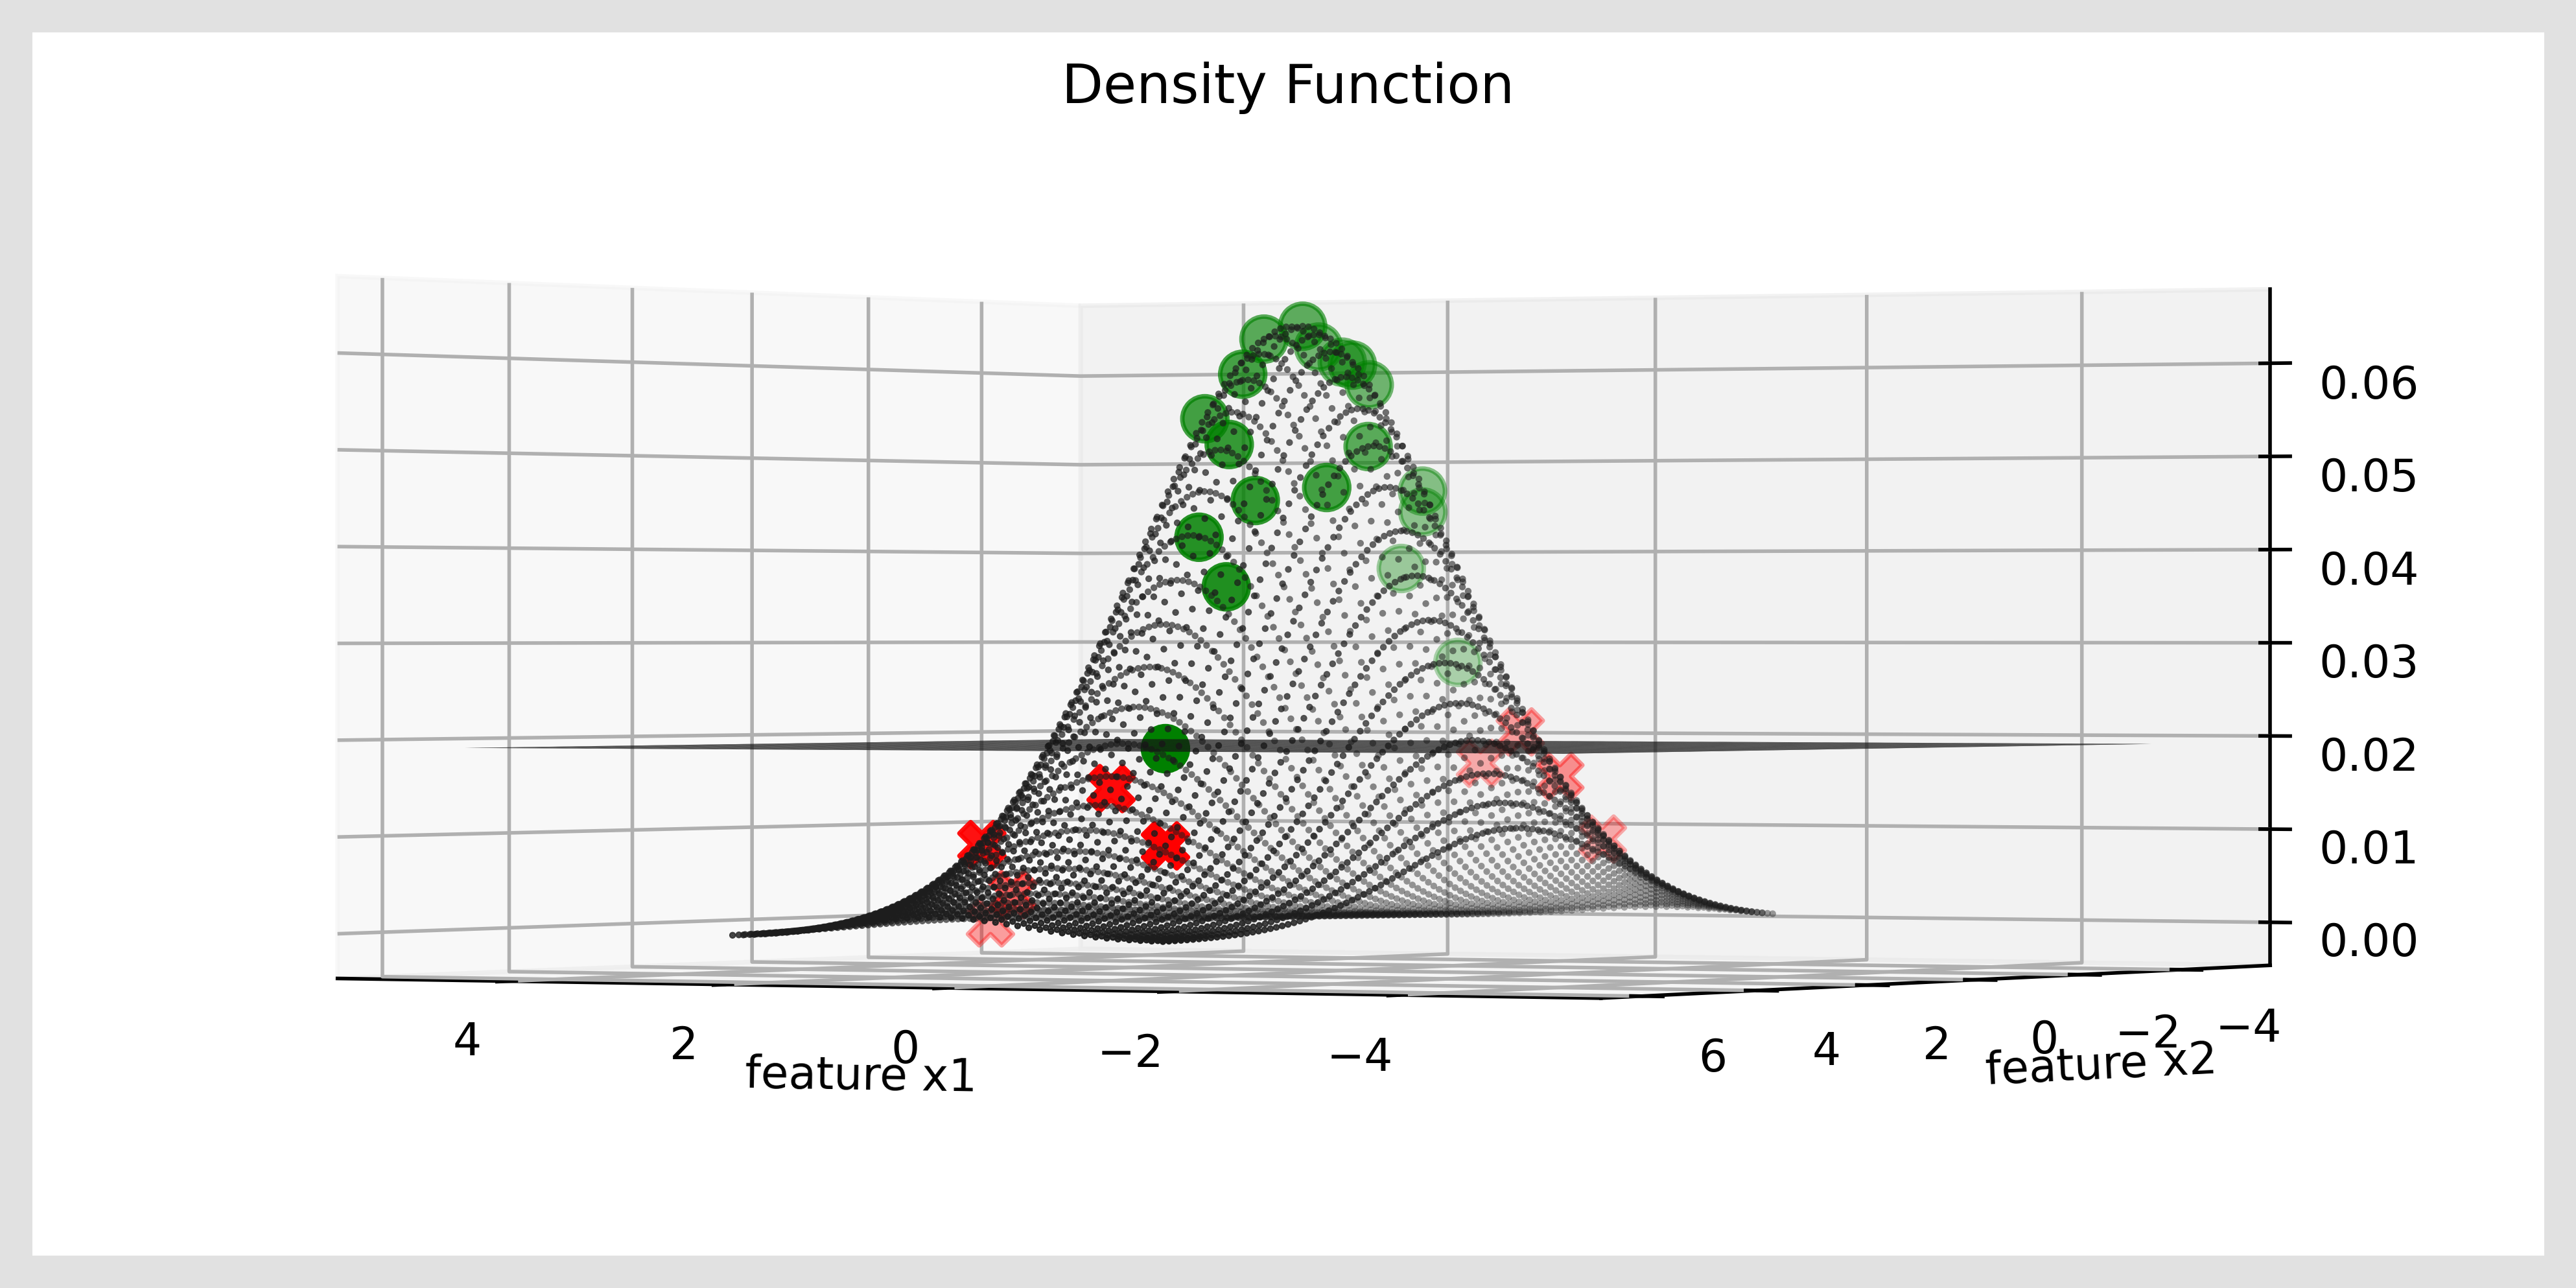

In [27]:
figure = plt.figure(figsize=(10, 5), dpi=500, facecolor='#e1e1e1')

ax1_3d = figure.add_subplot(111, projection='3d')

ax1_3d.scatter(x1_range, x2_range, y_range, marker='.', c='#1d1d1d', s=1)
ax1_3d.scatter(X1_True, X2_True, model.predict(X_range_true, prob=1), marker='X', c='r', s=100)
ax1_3d.scatter(X1_False, X2_False, model.predict(X_range_False, prob=1), marker='o', c='g', s=100)
xx, yy = np.meshgrid(np.arange(-5, 5, 0.1), np.arange(-5, 6, 0.1))
ax1_3d.plot_surface(xx, yy, np.array([[custom_thresh]]), color='#1d1d1d')


plt.xlabel('feature x1')
plt.ylabel('feature x2')
plt.clabel('density')

ax1_3d.set_title('Density Function')

ax1_3d.view_init(0, 120)

plt.show() 

We can understand the problem comes from two misplaced points (the green and the red ones near the threshold plane), in those situation we have the choice to shrink the curve on some feature or direct it by modifying the covariance matrix, or, just set another value to the threshold to get the best value of the metric we use, in this particular exemple we can set *custom_thresh* to a higher value and get a full recall!

In [28]:
th = custom_thresh

print('old threshold = ', th)
print('old recall = ', recall)

while recall != 1:
    cmat, precision, recall, _, _, = Mgd().fit(X, verbose=0).confusion_matrix(X, y, thresh=th)
    th += 1e-3 # increase threshold
    
print('____________________________________')    
print('new threshold = ', th)
print('new recall = ', recall)    
print('new precision = ', precision)
print('_______________________________________')
print('confusion matrix: ')
pd.DataFrame(data=cmat, columns=['predicted-as-1', 'predicted-as-0'], 
                          index=['actual-1', 'actual-0']).head(2)

old threshold =  0.01917111783905923
old recall =  0.8888888888888888
____________________________________
new threshold =  0.022171117839059232
new recall =  1.0
new precision =  0.9
_______________________________________
confusion matrix: 


,predicted-as-1,predicted-as-0
actual-1,9,0
actual-0,1,18


# Some References
***
1. [Wikipedia's Multivariate Gaussian Distribution Article](https://en.wikipedia.org/wiki/Multivariate_normal_distribution)
2. [Coursera Andrew Ng's Machine Learning Course ~ Anomaly Detection with the MGD](https://www.coursera.org/)